In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path
classLabels = ["granite", "coarse-grained granite", "fine-grained granite", "medium-grained granite" ]
print(torch.__version__)

1.6.0


In [32]:
df = pd.DataFrame({"image": sorted([ int(x.name.strip(".jpg")) for x in Path("original").iterdir()])})
df.image = df.image.astype(np.str)
print(df.dtypes)
df.image = df.image.str.cat([".jpg"]*len(df))
for label in classLabels:
  df[label]=0
with open("labels.json") as infile:
    s ="["
    s = s + ",".join(infile.readlines())
    s = s+"]"
    s = np.array(eval(s))
    s[s<0] = 0
    df.iloc[:,1:] = s
df.to_csv("data.csv",index=False)
print(df.head(10))

image    object
dtype: object
    image  granite  coarse-grained granite  fine-grained granite  \
0   1.jpg        1                       1                     0   
1   2.jpg        1                       1                     0   
2   3.jpg        1                       1                     0   
3   4.jpg        1                       1                     0   
4   5.jpg        1                       0                     1   
5   6.jpg        1                       0                     1   
6   7.jpg        1                       0                     1   
7   8.jpg        1                       0                     1   
8   9.jpg        1                       0                     1   
9  10.jpg        1                       0                     0   

   medium-grained granite  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0  
6                       0

In [33]:
class MyDataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None ):
    
    self.df = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transforms = transforms
    
  def __getitem__(self,idx):
    d = self.df.iloc[idx]
    image = Image.open(self.img_dir/d.image).convert("RGB")
    label = torch.tensor(d[1:].tolist() , dtype=torch.float32)
    
    if self.transforms is not None:
      image = self.transforms(image)
    return image,label
  
  def __len__(self):
    return len(self.df)

In [37]:
batch_size=32
transform = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

dataset = MyDataset("data.csv" , Path("original") , transform)
valid_no = int(len(dataset)*0.12) 
trainset ,valset  = random_split( dataset , [len(dataset) -valid_no  ,valid_no])
print(f"trainset len {len(trainset)} valset len {len(valset)}")
dataloader = {"train":DataLoader(trainset , shuffle=True , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=True , batch_size=batch_size)}

trainset len 13 valset len 1


In [38]:
model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)
## freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)

2048


In [39]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
  features_lst = [num_features , num_features//2 , num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

top_head = create_head(num_features , len(classLabels)) # because ten classes
model.fc = top_head # replace the fully connected layer

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [40]:
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [41]:
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer , num_epochs=5):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
      else:     # put the model in validation mode
        model.eval()
       
      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0  
      
      for data , target in data_loader[phase]:
        #load the data and target to respective device
        data , target = data.to(device)  , target.to(device)

        with torch.set_grad_enabled(phase=="train"):
          #feed the input
          output = model(data)
          #calculate the loss
          loss = criterion(output,target)
          preds = torch.sigmoid(output).data > 0.5
          preds = preds.to(torch.float32)
          
          if phase=="train"  :
            # backward pass: compute gradient of the loss with respect to model parameters 
            loss.backward()
            # update the model parameters
            optimizer.step()
            # zero the grad to stop it from accumulating
            optimizer.zero_grad()


        # statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
        
        
      epoch_loss = running_loss / len(data_loader[phase].dataset)
      epoch_acc = running_corrects / len(data_loader[phase].dataset)

      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print(result)

In [42]:
train(model,dataloader , criterion, optimizer,num_epochs=10)

Epochs:  20%|██        | 2/10 [00:02<00:11,  1.42s/it]['train Loss: 0.7946 Acc: 0.5103', 'val Loss: 0.7077 Acc: 0.5000']
['train Loss: 0.3874 Acc: 0.8410', 'val Loss: 0.7151 Acc: 0.5000']
Epochs:  40%|████      | 4/10 [00:02<00:04,  1.29it/s]['train Loss: 0.3130 Acc: 0.8308', 'val Loss: 0.7150 Acc: 0.5000']
['train Loss: 0.2985 Acc: 0.7949', 'val Loss: 0.7027 Acc: 0.5000']
Epochs:  60%|██████    | 6/10 [00:02<00:01,  2.19it/s]['train Loss: 0.2172 Acc: 0.8974', 'val Loss: 0.6853 Acc: 0.5000']
['train Loss: 0.2443 Acc: 0.7692', 'val Loss: 0.6541 Acc: 0.5000']
Epochs:  80%|████████  | 8/10 [00:02<00:00,  3.38it/s]['train Loss: 0.2434 Acc: 0.7949', 'val Loss: 0.6011 Acc: 0.8000']
['train Loss: 0.2287 Acc: 0.8718', 'val Loss: 0.5284 Acc: 0.8000']
Epochs: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]['train Loss: 0.1621 Acc: 0.9231', 'val Loss: 0.4598 Acc: 0.8000']
['train Loss: 0.1892 Acc: 0.8718', 'val Loss: 0.4015 Acc: 1.0000']



In [43]:
torch.save(model, "model.pt")

In [52]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

classLabels = ["granite", "coarse-grained granite", "fine-grained granite", "medium-grained granite" ]

In [53]:
model = torch.load('model.pt', map_location=torch.device('cpu'))
model = model.eval()

In [54]:
def get_tensor(img):
    tfms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    return tfms(Image.open(img)).unsqueeze(0)

In [72]:
def predict(img, label_lst, model):
    tnsr = get_tensor(img)
    op = model(tnsr)
    op_b = torch.round(op)
    
    op_b_np = torch.Tensor.cpu(op_b).detach().numpy()
    
    preds = np.where(op_b_np == 1)[1]
    
    sigs_op = torch.Tensor.cpu(torch.round((op)*100)).detach().numpy()[0]
    
    o_p = np.argsort(torch.Tensor.cpu(op).detach().numpy())[0][::-1]
    
    # print("Argsort: {}".format(o_p))
    # print("Softmax: {}".format(sigs_op))
    
    # print(preds)
    
    label = []
    for i in preds:
        label.append(label_lst[i])
        
    arg_s = {}
    for i in o_p:
#         arg_s.append(label_lst[int(i)])
        arg_s[label_lst[int(i)]] = sigs_op[int(i)]
    
    exist = []
    for i in range(4):
        if list(arg_s.items())[i][1] > 50:
            exist.append(list(arg_s.items())[i][0])
        
    print("existing object: {}".format(exist))
        
    # return label, list(arg_s.items())[:10]

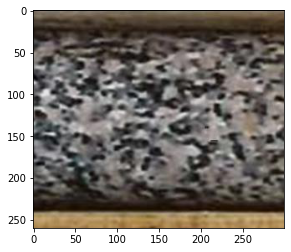

existing object: [('coarse-grained granite', 92.0), ('granite', 19.0), ('medium-grained granite', -7.0), ('fine-grained granite', -130.0)]


In [73]:
path = 'photo/coarse.jpg'
image = plt.imread(path)
plt.imshow(image)
plt.show()
predict(path, classLabels, model)